### 0) Setup & load

In [47]:
# --- Setup & Load ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional KDE (use if available)
try:
    from scipy.stats import gaussian_kde
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

# Load your file (same name we saved before)
PATH = r"data/synthetic_clinical_dataset.csv"
df = pd.read_csv(PATH)

# basic split
cases = df[df["diagnosis_label"] == 1].copy()
controls = df[df["diagnosis_label"] == 0].copy()

df.head()


,age,menopausal_status,bmi,parity,family_history,mht_use,brca_status,ca125,ultrasound_risk_score,tumor_size_cm,diagnosis_label
0,36,0,27.60,2,0,0,0,21.7,0.012,0.00,0
1,56,1,27.67,1,0,0,0,20.1,0.012,0.00,0
2,45,1,35.00,0,0,1,0,9.0,0.009,0.00,0
3,41,0,23.16,2,0,0,0,10.9,0.009,0.00,0
4,51,0,22.75,3,1,0,0,32.5,0.342,10.21,1


### 1) Distribution plots (overall + stratified by diagnosis)

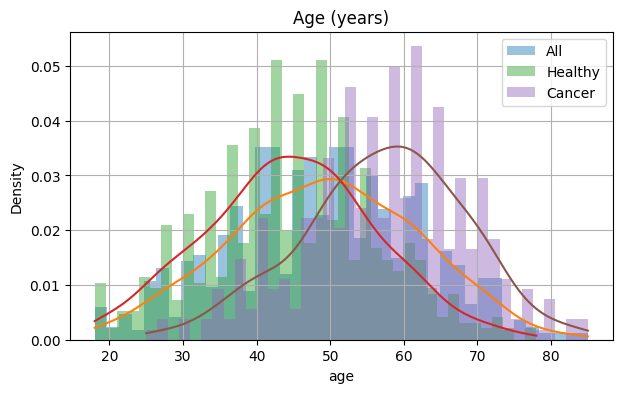

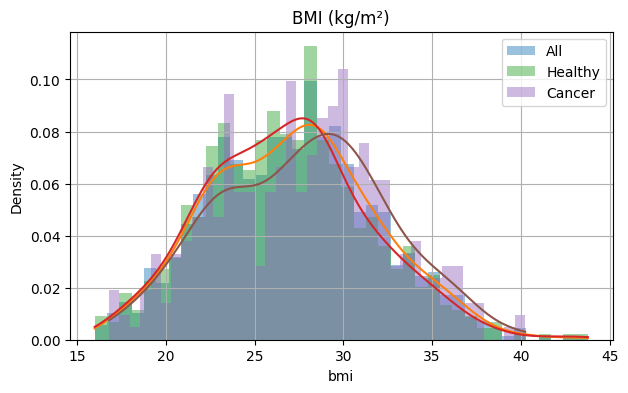

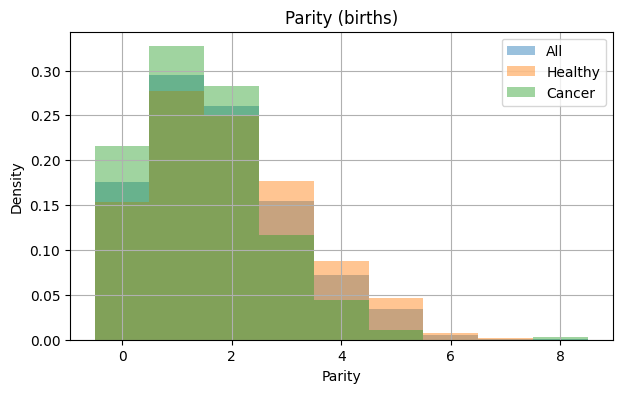

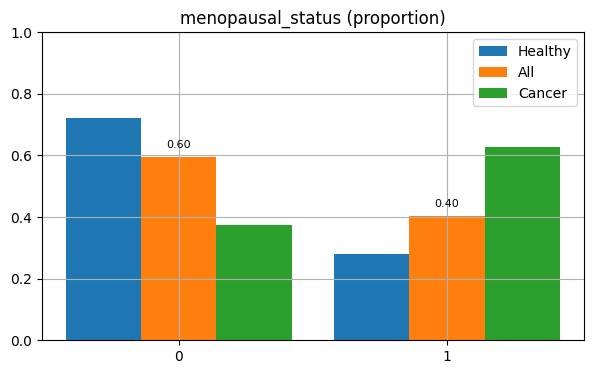

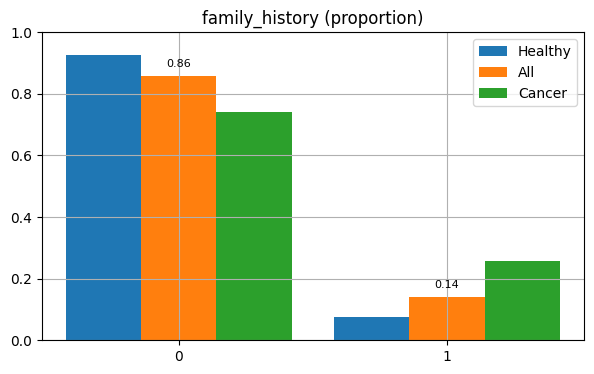

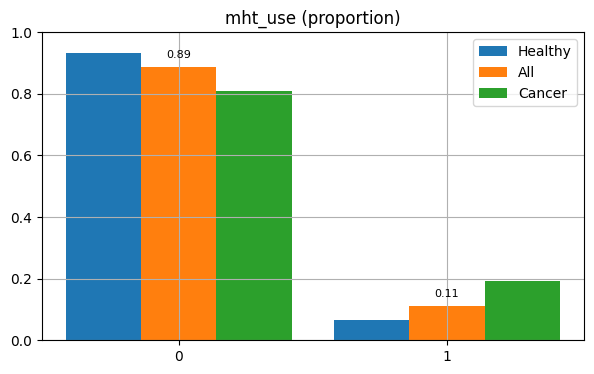

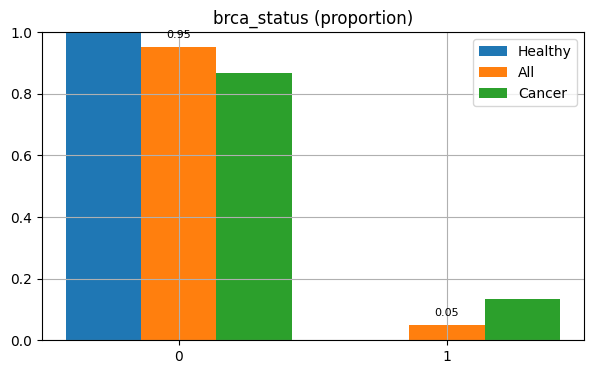

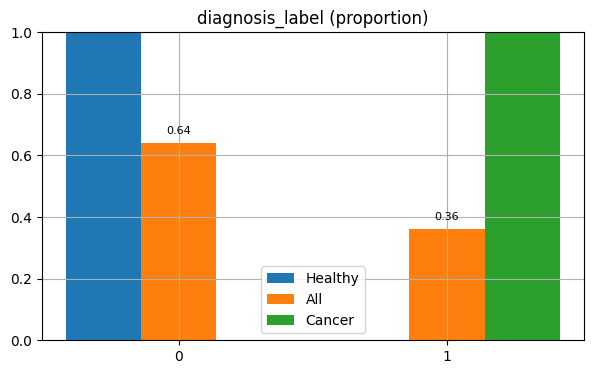

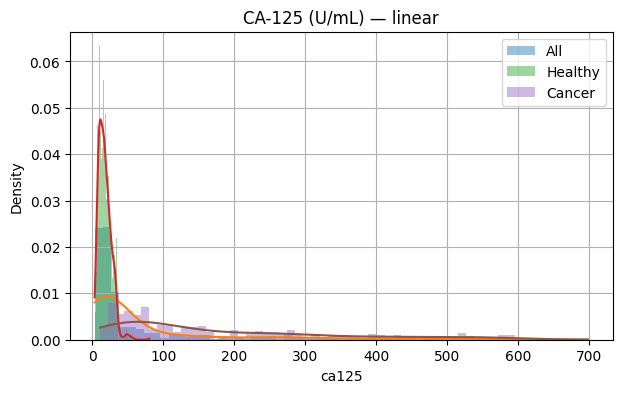

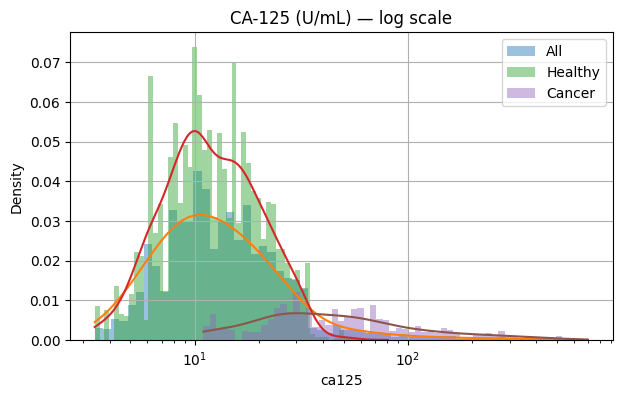

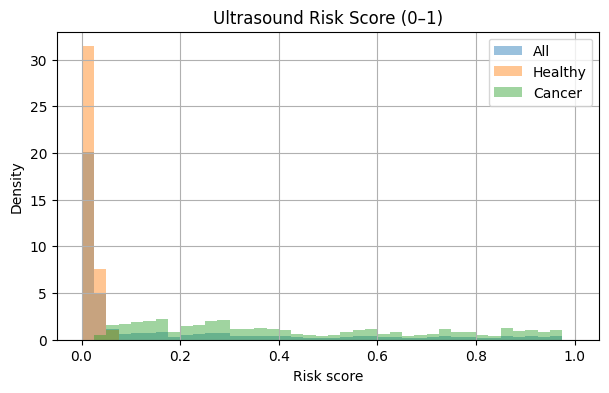

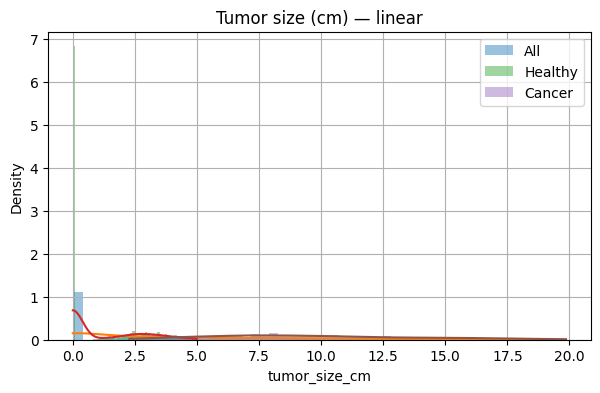

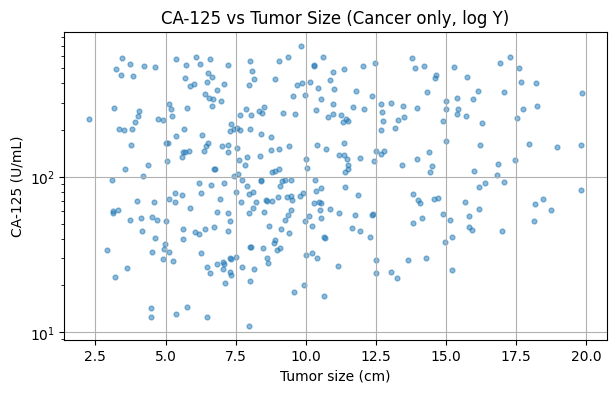

In [49]:
# --- Imports & setup you need once ---
import numpy as np
import matplotlib.pyplot as plt

# Optional KDE (works even if SciPy isn't installed)
try:
    from scipy.stats import gaussian_kde
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# Group splits used below
controls = df[df["diagnosis_label"] == 0]
cases    = df[df["diagnosis_label"] == 1]

# --- Helpers for plotting ---

def plot_hist_kde(ax, data, bins=40, label=None, logx=False):
    """
    Plots a normalized histogram (density=True) and an optional KDE overlay.
    - On log x: uses log-spaced bins (geomspace) so bar areas make sense.
    - KDE on log x: we fit KDE in log-space and apply the change-of-variables
      (divide by x) so the curve is in the original units.
    """
    arr = np.asarray(pd.Series(data).dropna(), dtype=float)
    if arr.size == 0:
        return

    if logx:
        arr = arr[arr > 0]  # log scale requires positive data
        if arr.size == 0:   # nothing positive to plot
            return
        ax.set_xscale("log")
        # Use log-spaced bin edges so "density=True" is meaningful
        left  = max(arr.min(), 1e-6)
        right = arr.max()
        edges = np.geomspace(left, right, bins + 1)
    else:
        edges = bins

    # Histogram (semi-transparent so curves/overlays are visible)
    ax.hist(arr, bins=edges, alpha=0.45, label=label, density=True, edgecolor="none")

    # KDE overlay (optional)
    if _HAS_SCIPY and arr.size > 1 and np.isfinite(arr).all():
        try:
            if logx:
                # Fit KDE in log-space and transform back (divide by x)
                y  = np.log(arr)
                kde = gaussian_kde(y)
                xs_log = np.linspace(y.min(), y.max(), 256)
                xs_lin = np.exp(xs_log)
                dens   = kde(xs_log) / xs_lin  # change-of-variables: f_X(x) = f_Y(log x)/x
                ax.plot(xs_lin, dens)
            else:
                kde = gaussian_kde(arr)
                xs = np.linspace(arr.min(), arr.max(), 256)
                ax.plot(xs, kde(xs))
        except Exception:
            pass

def plot_feature_distribution(feature, title=None, bins=40, logx=False):
    fig, ax = plt.subplots()
    plot_hist_kde(ax, df[feature],       bins=bins, label="All",     logx=logx)
    plot_hist_kde(ax, controls[feature], bins=bins, label="Healthy", logx=logx)
    plot_hist_kde(ax, cases[feature],    bins=bins, label="Cancer",  logx=logx)
    ax.set_title(title or feature)
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()
    plt.show()

# --- Plot each (continuous) feature ---

plot_feature_distribution("age", "Age (years)")
plot_feature_distribution("bmi", "BMI (kg/m²)")

# Parity is discrete; use integer-centered bins for cleaner bars
fig, ax = plt.subplots()
par_all  = df["parity"].dropna().astype(int)
par_bins = np.arange(-0.5, par_all.max() + 1.5, 1)  # centers bars on integers
ax.hist(par_all, bins=par_bins, density=True, alpha=0.45, label="All", edgecolor="none")
ax.hist(controls["parity"], bins=par_bins, density=True, alpha=0.45, label="Healthy", edgecolor="none")
ax.hist(cases["parity"],    bins=par_bins, density=True, alpha=0.45, label="Cancer",  edgecolor="none")
ax.set_title("Parity (births)")
ax.set_xlabel("Parity")
ax.set_ylabel("Density")
ax.legend()
plt.show()

# Binary features: stacked/grouped bars are more informative than a single overall bar
for col in ["menopausal_status","family_history","mht_use","brca_status","diagnosis_label"]:
    fig, ax = plt.subplots()
    vc_all  = df[col].value_counts(normalize=True).sort_index()
    vc_ctrl = controls[col].value_counts(normalize=True).reindex(vc_all.index, fill_value=0)
    vc_case = cases[col].value_counts(normalize=True).reindex(vc_all.index, fill_value=0)

    idx = np.arange(len(vc_all.index))
    w   = 0.28
    ax.bar(idx - w, vc_ctrl.values, width=w, label="Healthy")
    ax.bar(idx      , vc_all.values, width=w, label="All")
    ax.bar(idx + w,  vc_case.values, width=w, label="Cancer")

    ax.set_xticks(idx); ax.set_xticklabels(vc_all.index.astype(str))
    ax.set_ylim(0, 1)
    ax.set_title(f"{col} (proportion)")
    for i, v in enumerate(vc_all.values):
        ax.text(i, min(v + 0.03, 0.98), f"{v:.2f}", ha="center", fontsize=8)
    ax.legend()
    plt.show()

# CA-125 is skewed; show linear + log scale (log uses log-spaced bins & proper KDE)
plot_feature_distribution("ca125", "CA-125 (U/mL) — linear", bins=60, logx=False)
plot_feature_distribution("ca125", "CA-125 (U/mL) — log scale", bins=60, logx=True)

# Ultrasound risk (0–1): fix bins to a uniform grid for cleaner look
fig, ax = plt.subplots()
edges01 = np.linspace(0, 1, 41)
ax.hist(df["ultrasound_risk_score"], bins=edges01, density=True, alpha=0.45, label="All", edgecolor="none")
ax.hist(controls["ultrasound_risk_score"], bins=edges01, density=True, alpha=0.45, label="Healthy", edgecolor="none")
ax.hist(cases["ultrasound_risk_score"],    bins=edges01, density=True, alpha=0.45, label="Cancer",  edgecolor="none")
ax.set_title("Ultrasound Risk Score (0–1)")
ax.set_xlabel("Risk score")
ax.set_ylabel("Density")
ax.legend()
plt.show()

# Tumor size (linear scale is fine; you can add a log version if you like)
plot_feature_distribution("tumor_size_cm", "Tumor size (cm) — linear", bins=50, logx=False)

# Optional: scatter to visualize intended correlation (cases only)
fig, ax = plt.subplots()
ax.scatter(cases["tumor_size_cm"], cases["ca125"], s=12, alpha=0.5)
ax.set_xlabel("Tumor size (cm)")
ax.set_ylabel("CA-125 (U/mL)")
ax.set_yscale("log")
ax.set_title("CA-125 vs Tumor Size (Cancer only, log Y)")
plt.show()


### 2) Correlation matrix (+ brief clinical readout)

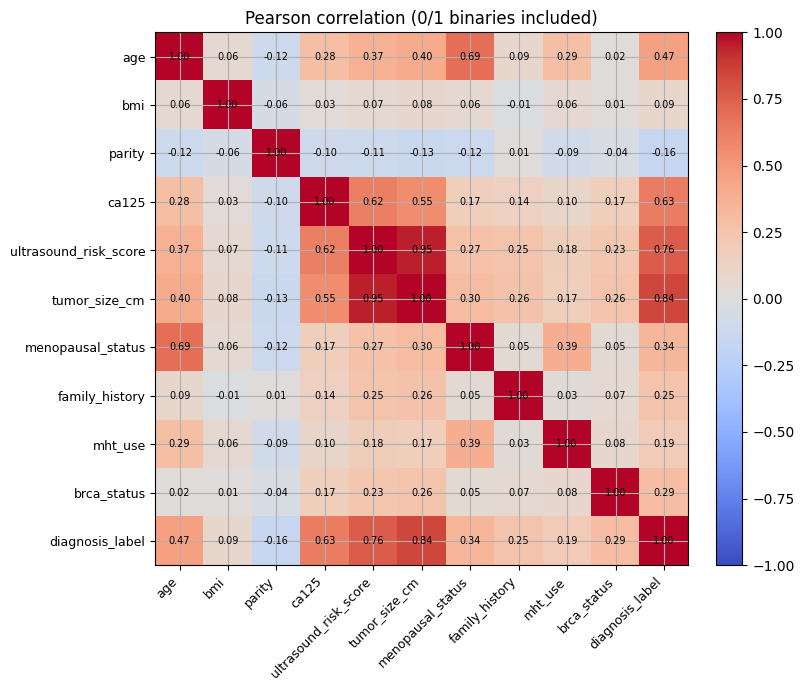

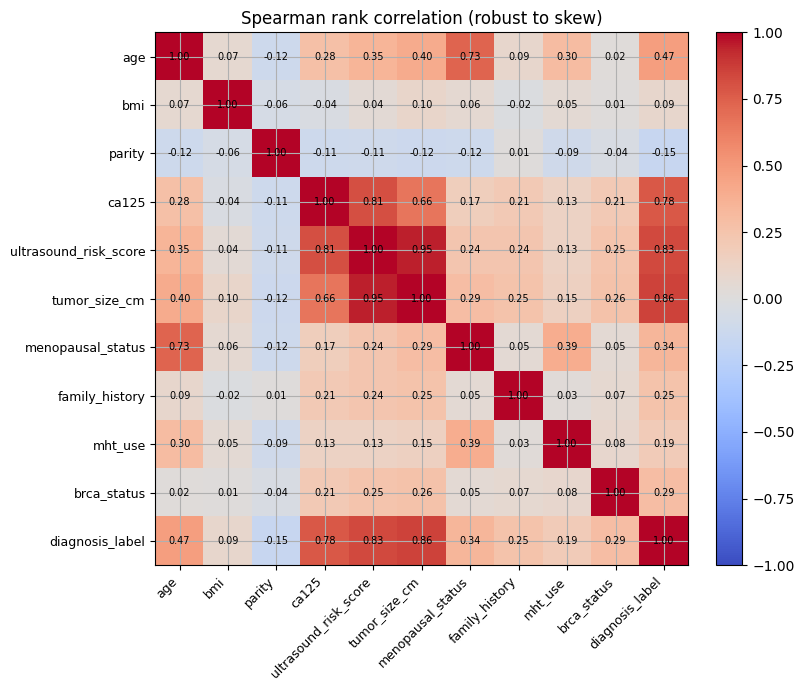


Selected correlations (Pearson, ALL rows):
tumor_size_cm          vs ca125                   : r =  0.555
tumor_size_cm          vs ultrasound_risk_score   : r =  0.950
ca125                  vs ultrasound_risk_score   : r =  0.624
age                    vs menopausal_status       : r =  0.691
family_history         vs brca_status             : r =  0.068
brca_status            vs age                     : r =  0.018

Selected correlations (Pearson, CASES only):
tumor_size_cm          vs ca125                   : r =  0.072
tumor_size_cm          vs ultrasound_risk_score   : r =  0.960
ca125                  vs ultrasound_risk_score   : r =  0.289
age                    vs menopausal_status       : r =  0.603
family_history         vs brca_status             : r = -0.007
brca_status            vs age                     : r = -0.243

Selected correlations (Spearman, CASES only):
tumor_size_cm          vs ca125                   : ρ =  0.105
tumor_size_cm          vs ultrasound_risk_sc

In [51]:
import matplotlib.pyplot as plt  # <-- missing import

# Treat binaries as 0/1 numeric and compute Pearson & Spearman
numeric_cols = [
    "age","bmi","parity","ca125","ultrasound_risk_score","tumor_size_cm",
    "menopausal_status","family_history","mht_use","brca_status","diagnosis_label"
]

corr_pearson  = df[numeric_cols].corr(method="pearson")
corr_spearman = df[numeric_cols].corr(method="spearman")

def plot_corr(mat, title):
    fig, ax = plt.subplots(figsize=(8.5, 7))
    im = ax.imshow(mat.values, cmap="coolwarm", vmin=-1, vmax=1)  # use values
    ax.set_xticks(range(len(mat.columns))); ax.set_yticks(range(len(mat.index)))
    ax.set_xticklabels(mat.columns, rotation=45, ha="right", fontsize=9)
    ax.set_yticklabels(mat.index, fontsize=9)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    # annotate cells (can be busy on small screens)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat.iat[i, j]
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black", fontsize=7)
    plt.tight_layout()
    plt.show()

plot_corr(corr_pearson,  "Pearson correlation (0/1 binaries included)")
plot_corr(corr_spearman, "Spearman rank correlation (robust to skew)")

# -------- Targeted checks --------
# If you want the "in cancer" relationships, compute on the case-only subset.
df_case = df[df["diagnosis_label"] == 1]
df_ctrl = df[df["diagnosis_label"] == 0]

pairs_to_peek = [
    ("tumor_size_cm","ca125"),                 # + in cancer
    ("tumor_size_cm","ultrasound_risk_score"), # strong +
    ("ca125","ultrasound_risk_score"),         # moderate +
    ("age","menopausal_status"),               # strong + (across all)
    ("family_history","brca_status"),          # + (across all)
    ("brca_status","age"),                     # negative (BRCA+ younger)
]

print("\nSelected correlations (Pearson, ALL rows):")
for a,b in pairs_to_peek:
    r = df[[a,b]].corr(method="pearson").loc[a,b]
    print(f"{a:<22s} vs {b:<24s}: r = {r: .3f}")

print("\nSelected correlations (Pearson, CASES only):")
for a,b in pairs_to_peek:
    # Skip pairs that don't make sense case-only (e.g., age↔menopause is fine either way)
    r = df_case[[a,b]].corr(method="pearson").loc[a,b]
    print(f"{a:<22s} vs {b:<24s}: r = {r: .3f}")

print("\nSelected correlations (Spearman, CASES only):")
for a,b in pairs_to_peek:
    r = df_case[[a,b]].corr(method="spearman").loc[a,b]
    print(f"{a:<22s} vs {b:<24s}: ρ = {r: .3f}")


### 3) Plausibility checks vs our targets (pass/fail)

In [53]:
import numpy as np
import pandas as pd

def pct(x): 
    try: return 100*float(x)
    except: return np.nan

def report(desc, ok, val):
    status = "PASS" if ok else "FAIL"
    # Pretty-print tuples and scalars
    if isinstance(val, tuple):
        v = ", ".join(f"{x:.3f}" if isinstance(x, (int,float,np.floating)) else str(x) for x in val)
    elif isinstance(val, (int,float,np.floating)):
        v = f"{val:.3f}"
    else:
        v = str(val)
    print(f"[{status}] {desc:<60} -> {v}")

controls = df[df["diagnosis_label"] == 0]
cases    = df[df["diagnosis_label"] == 1]

checks = []

# --- Cohort composition ---
prev = df["diagnosis_label"].mean()
checks.append(("Cancer fraction ≥ 30%", prev >= 0.30, prev))

# --- BRCA prevalence ---
brca_case_rate = cases["brca_status"].mean() if len(cases) else np.nan
checks.append(("BRCA+ among cases in [12%, 18%]", 0.12 <= brca_case_rate <= 0.18, brca_case_rate))

# --- CA-125 behavior ---
healthy_high35 = (controls["ca125"] > 35).mean() if len(controls) else np.nan
case_high200   = (cases["ca125"] > 200).mean() if len(cases) else np.nan
checks.append(("Healthy CA-125 >35 U/mL ≈ 1–3%", 0.01 <= healthy_high35 <= 0.03, healthy_high35))
checks.append(("Cancer CA-125 >200 U/mL ≥ 35%", case_high200 >= 0.35, case_high200))

# --- Tumor size ---
median_size_cases = cases["tumor_size_cm"].median() if len(cases) else np.nan
nz_ctrl = controls.loc[controls["tumor_size_cm"] > 0, "tumor_size_cm"]
median_size_ctrl_nonzero = nz_ctrl.median() if len(nz_ctrl) else np.nan
checks.append(("Median tumor size (cases) in [8, 11] cm", 8.0 <= median_size_cases <= 11.0, median_size_cases))
if pd.notna(median_size_ctrl_nonzero):
    checks.append(("Median benign cyst (controls) in [2, 4] cm", 2.0 <= median_size_ctrl_nonzero <= 4.0, median_size_ctrl_nonzero))

# Zero-mass proportion in controls (expect high; ~60–80%)
zero_mass_rate = (controls["tumor_size_cm"] == 0).mean() if len(controls) else np.nan
checks.append(("Controls: zero-mass proportion in [0.6, 0.8]", 0.60 <= zero_mass_rate <= 0.80, zero_mass_rate))

# --- Ultrasound risk sanity ---
mean_risk_cases = cases["ultrasound_risk_score"].mean() if len(cases) else np.nan
mean_risk_ctrls = controls["ultrasound_risk_score"].mean() if len(controls) else np.nan
checks.append(("Mean risk (cases) > Mean risk (controls)", mean_risk_cases > mean_risk_ctrls, (mean_risk_cases, mean_risk_ctrls)))

# Controls w/ no mass should be very low risk (use 95th percentile to avoid mean skew)
no_mass = controls.loc[controls["tumor_size_cm"] == 0, "ultrasound_risk_score"]
q95 = no_mass.quantile(0.95) if len(no_mass) else np.nan
checks.append(("Controls no-mass: 95th percentile risk ≤ 0.08", q95 <= 0.08, q95))

# --- Menopause / MHT checks ---
p_post_55 = (df.loc[df["age"] >= 55, "menopausal_status"].mean()
             if (df["age"] >= 55).any() else np.nan)
checks.append(("P(postmenopause | age ≥ 55) in [0.80, 0.90]", 0.80 <= p_post_55 <= 0.90, p_post_55))

mht_post_ctrl = controls.loc[controls["menopausal_status"] == 1, "mht_use"].mean() if (controls["menopausal_status"] == 1).any() else np.nan
mht_post_case = cases.loc[cases["menopausal_status"] == 1, "mht_use"].mean() if (cases["menopausal_status"] == 1).any() else np.nan
checks.append(("MHT among post-menopause (controls) ≈ 0.20±0.05", 0.15 <= mht_post_ctrl <= 0.25, mht_post_ctrl))
checks.append(("MHT among post-menopause (cases) ≈ 0.25±0.05", 0.20 <= mht_post_case <= 0.30, mht_post_case))

# --- Hemodilution sanity (controls only): BMI vs CA-125 should be negative ---
rho_bmi_ca125_ctrl = controls[["bmi","ca125"]].corr(method="spearman").iloc[0,1] if len(controls) else np.nan
checks.append(("Controls: Spearman(BMI, CA-125) < 0", rho_bmi_ca125_ctrl < 0, rho_bmi_ca125_ctrl))

# --- Within-cases correlations (intended behavior) ---
def safe_corr(df_sub, a, b, method="spearman"):
    if len(df_sub) < 3 or df_sub[[a,b]].dropna().shape[0] < 3:
        return np.nan
    return df_sub[[a,b]].corr(method=method).iloc[0,1]

rho_size_risk_case  = safe_corr(cases, "tumor_size_cm", "ultrasound_risk_score")
rho_ca_risk_case    = safe_corr(cases, "ca125", "ultrasound_risk_score")
rho_size_ca_case    = safe_corr(cases, "tumor_size_cm", "ca125")

checks.append(("Cases: corr(size, risk) > 0.5", rho_size_risk_case > 0.5, rho_size_risk_case))
checks.append(("Cases: corr(CA-125, risk) in [0.3, 0.5]", 0.3 <= rho_ca_risk_case <= 0.5, rho_ca_risk_case))
checks.append(("Cases: corr(size, CA-125) > 0", rho_size_ca_case > 0.0, rho_size_ca_case))

# --- BRCA & age relationship (you already had this; keeping it) ---
med_age_brca1 = cases.loc[cases["brca_status"]==1, "age"].median() if (cases["brca_status"]==1).any() else np.nan
med_age_brca0 = cases.loc[cases["brca_status"]==0, "age"].median() if (cases["brca_status"]==0).any() else np.nan
checks.append(("BRCA+ cases skew younger (median)", med_age_brca1 < med_age_brca0, (med_age_brca1, med_age_brca0)))

# --- Hard bounds sanity (no impossible values) ---
ok_bounds = (
    (df["bmi"].between(16, 45).all()) and
    (df["age"].between(18, 90).all()) and
    (df["ca125"].between(2, 2000).all()) and
    (df.loc[df["diagnosis_label"]==1, "tumor_size_cm"].between(0.5, 20).all()) and
    (df.loc[df["diagnosis_label"]==0, "tumor_size_cm"].ge(0).all())
)
checks.append(("All features within specified bounds", ok_bounds, ok_bounds))

# --- Print report ---
print("Plausibility checks:")
for desc, ok, val in checks:
    report(desc, ok, val)


Plausibility checks:
[PASS] Cancer fraction ≥ 30%                                        -> 0.361
[PASS] BRCA+ among cases in [12%, 18%]                              -> 0.133
[PASS] Healthy CA-125 >35 U/mL ≈ 1–3%                               -> 0.019
[PASS] Cancer CA-125 >200 U/mL ≥ 35%                                -> 0.352
[PASS] Median tumor size (cases) in [8, 11] cm                      -> 9.050
[PASS] Median benign cyst (controls) in [2, 4] cm                   -> 2.900
[PASS] Controls: zero-mass proportion in [0.6, 0.8]                 -> 0.681
[PASS] Mean risk (cases) > Mean risk (controls)                     -> 0.426, 0.017
[PASS] Controls no-mass: 95th percentile risk ≤ 0.08                -> 0.014
[PASS] P(postmenopause | age ≥ 55) in [0.80, 0.90]                  -> 0.853
[PASS] MHT among post-menopause (controls) ≈ 0.20±0.05              -> 0.242
[PASS] MHT among post-menopause (cases) ≈ 0.25±0.05                 -> 0.279
[PASS] Controls: Spearman(BMI, CA-125) < 0      

### 4) Edge-case validation (no impossible values)

In [55]:
# --- Concise measures + strict assertions in one cell ---

import numpy as np
import pandas as pd
from pandas.api.types import is_integer_dtype, is_bool_dtype, is_numeric_dtype

# Masks & splits
ctrl = df["diagnosis_label"] == 0
case = df["diagnosis_label"] == 1
controls = df[ctrl]
cases    = df[case]

# Helpers
def fmt_pct(x):
    return f"{100*float(x):.1f}%" if pd.notna(x) else "NA"

def safe_mean(s):   return float(s.mean())   if len(s) else np.nan
def safe_median(s): return float(s.median()) if len(s) else np.nan
def safe_prop(s):   return float(s.mean())   if len(s) else np.nan

def safe_corr(df_sub, a, b, method="spearman"):
    try:
        sub = df_sub[[a,b]].dropna()
        if len(sub) < 3: return np.nan
        return float(sub.corr(method=method).iloc[0,1])
    except Exception:
        return np.nan

# ---------- Concise measures ----------
n = len(df); n_case = int(case.sum()); n_ctrl = int(ctrl.sum())

brca_case_rate = safe_prop(cases["brca_status"])
healthy_high35 = safe_prop((controls["ca125"] > 35).astype(int))
case_high200   = safe_prop((cases["ca125"]   > 200).astype(int))

median_size_cases         = safe_median(cases["tumor_size_cm"])
median_size_ctrl_nonzero  = safe_median(controls.loc[controls["tumor_size_cm"]>0, "tumor_size_cm"])
zero_mass_rate            = safe_prop((controls["tumor_size_cm"] == 0).astype(int))

mean_risk_cases = safe_mean(cases["ultrasound_risk_score"])
mean_risk_ctrls = safe_mean(controls["ultrasound_risk_score"])

p_post_55      = safe_prop(df.loc[df["age"] >= 55, "menopausal_status"])
mht_post_ctrl  = safe_prop(controls.loc[controls["menopausal_status"] == 1, "mht_use"])
mht_post_case  = safe_prop(cases.loc[cases["menopausal_status"] == 1, "mht_use"])

rho_bmi_ca125_ctrl = safe_corr(controls, "bmi", "ca125", "spearman")
rho_size_risk_case = safe_corr(cases,    "tumor_size_cm", "ultrasound_risk_score", "spearman")
rho_ca_risk_case   = safe_corr(cases,    "ca125",         "ultrasound_risk_score", "spearman")
rho_size_ca_case   = safe_corr(cases,    "tumor_size_cm", "ca125", "spearman")

print("=== Concise verification measures ===")
print(f"N={n} | Controls={n_ctrl} | Cases={n_case} | Cancer prevalence={fmt_pct(n_case/n)}")
print(f"BRCA+ among cases: {fmt_pct(brca_case_rate)} (target 12–18%)")
print(f"Healthy CA-125 >35: {fmt_pct(healthy_high35)} (target 1–3%)")
print(f"Cases CA-125 >200: {fmt_pct(case_high200)} (≥35% desired)")
print(f"Median tumor size — cases: {median_size_cases:.2f} cm (target 8–11)")
print(f"Median benign cyst — controls: {median_size_ctrl_nonzero:.2f} cm (target 2–4)")
print(f"Controls zero-mass proportion: {fmt_pct(zero_mass_rate)} (target 60–80%)")
print(f"Mean risk — controls: {mean_risk_ctrls:.3f} | cases: {mean_risk_cases:.3f}")
print(f"P(postmenopause | age≥55): {fmt_pct(p_post_55)} (target 80–90%)")
print(f"MHT among post-menopause — controls: {fmt_pct(mht_post_ctrl)} | cases: {fmt_pct(mht_post_case)} (~20% | ~25%)")
print(f"Spearman(size, risk) in cases: {rho_size_risk_case:.3f} (>0.5)")
print(f"Spearman(CA-125, risk) in cases: {rho_ca_risk_case:.3f} (0.3–0.5)")
print(f"Spearman(size, CA-125) in cases: {rho_size_ca_case:.3f} (>0)")
print(f"Spearman(BMI, CA-125) in controls: {rho_bmi_ca125_ctrl:.3f} (<0 expected)\n")

# ---------- Strict assertions (spec-aligned) ----------

# Global ranges
assert df["age"].between(18, 90).all(), "Age out of bounds [18,90]"
assert df["bmi"].between(16, 45).all(), "BMI out of bounds [16,45]"
assert df["parity"].between(0, 8).all(), "Parity out of bounds [0,8]"
assert df["ca125"].between(2, 2000).all(), "CA-125 out of bounds [2,2000]"
assert (df["ultrasound_risk_score"] >= 0).all() and (df["ultrasound_risk_score"] <= 0.99 + 1e-9).all(), "Risk score out of [0,0.99]"

# Tumor size (class-conditional)
assert df.loc[case, "tumor_size_cm"].between(0.5, 20).all(), "Case tumor size out of [0.5,20]"
ctrl_sizes = df.loc[ctrl, "tumor_size_cm"]
assert (ctrl_sizes >= 0).all(), "Control tumor size has negatives"
ctrl_nonzero = ctrl_sizes[ctrl_sizes > 0]
assert ctrl_nonzero.empty or ctrl_nonzero.between(1.0, 5.0).all(), "Control benign cyst size out of [1,5]"

# Binaries: values + dtype
bin_cols = ["menopausal_status","family_history","mht_use","brca_status","diagnosis_label"]
for col in bin_cols:
    vals = set(pd.unique(df[col].dropna()))
    assert vals <= {0, 1}, f"Non-binary values found in {col}: {vals}"
    assert is_integer_dtype(df[col]) or is_bool_dtype(df[col]), f"{col} is not integer/bool dtype"

# Integer-like columns strictly integer
int_like_cols = ["age","parity"] + bin_cols
for col in int_like_cols:
    assert is_numeric_dtype(df[col]), f"{col} not numeric"
    assert np.array_equal(df[col].values, df[col].astype(int).values), f"{col} contains non-integer values"

# No missing values
na_counts = df.isna().sum()
assert int(na_counts.sum()) == 0, f"Found NaNs:\n{na_counts[na_counts>0]}"

print("Edge-case validation COMPLETE ✅")


=== Concise verification measures ===
N=1000 | Controls=639 | Cases=361 | Cancer prevalence=36.1%
BRCA+ among cases: 13.3% (target 12–18%)
Healthy CA-125 >35: 1.9% (target 1–3%)
Cases CA-125 >200: 35.2% (≥35% desired)
Median tumor size — cases: 9.05 cm (target 8–11)
Median benign cyst — controls: 2.90 cm (target 2–4)
Controls zero-mass proportion: 68.1% (target 60–80%)
Mean risk — controls: 0.017 | cases: 0.426
P(postmenopause | age≥55): 85.3% (target 80–90%)
MHT among post-menopause — controls: 24.2% | cases: 27.9% (~20% | ~25%)
Spearman(size, risk) in cases: 0.960 (>0.5)
Spearman(CA-125, risk) in cases: 0.361 (0.3–0.5)
Spearman(size, CA-125) in cases: 0.105 (>0)
Spearman(BMI, CA-125) in controls: -0.254 (<0 expected)

Edge-case validation COMPLETE ✅
